In [1]:
from unet import *
from res_unet import *
from data import *
from matplotlib import pyplot as plt
from random import randrange
# from sklearn.metrics import precision_score, roc_curve
import os
import pandas as pd

from keras.utils import plot_model

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

%matplotlib inline

Using TensorFlow backend.


In [2]:
input_shape = (128,128)

model_names = ['unet_bus_base_w_normals' , 'unet_bus_base_w_normals_aug', 
               'unet_bus_base+batchnorm_w_normals' , 'unet_bus_base+batchnorm_w_normals_aug',
               'res_unet_bus_base_w_normals' , 'res_unet_bus_base_w_normals_aug',
               'res_unet_bus_base+batchnorm_w_normals' , 'res_unet_bus_base+batchnorm_w_normals_aug']

#unet with no augmentation w batchnorm
base_unet_no_aug = unet(batchnorm = False,input_size=input_shape+(1,))
base_unet_no_aug.load_weights('trained_models/{}.hdf5'.format(model_names[0]))
                              
#unet with w batchnorm
base_unet_aug = unet(batchnorm = False, input_size=input_shape+(1,))
base_unet_aug.load_weights('trained_models/{}.hdf5'.format(model_names[1]))
                           
#unet with no augmentation w batchnorm
unet_no_aug = unet(batchnorm = True, input_size=input_shape+(1,))
unet_no_aug.load_weights('trained_models/{}.hdf5'.format(model_names[2]))
                         
#unet with w batchnorm
unet_aug = unet(batchnorm = True, input_size=input_shape+(1,))
unet_aug.load_weights('trained_models/{}.hdf5'.format(model_names[3]))
     
#resunet with no augmentation without batchnorm
res_unet_no_bn_no_aug = res_unet(batchnorm = False,input_size=input_shape+(1,))
res_unet_no_bn_no_aug.load_weights('trained_models/{}.hdf5'.format(model_names[4]))
                             
#resunet with aug without batchnorm
res_unet_no_bn_aug = res_unet(batchnorm = False, input_size=input_shape+(1,))
res_unet_no_bn_aug.load_weights('trained_models/{}.hdf5'.format(model_names[5])) 
       
#resunet with no augmentation w batchnorm
res_unet_no_aug = res_unet(batchnorm = True, input_size=input_shape+(1,))
res_unet_no_aug.load_weights('trained_models/{}.hdf5'.format(model_names[6]))
                             
#resunet with aug w batchnorm
res_unet_aug = res_unet(batchnorm = True, input_size=input_shape+(1,))
res_unet_aug.load_weights('trained_models/{}.hdf5'.format(model_names[7]))
                          
seg_model = {model_names[0]:base_unet_no_aug,
             model_names[1]:base_unet_aug,
             model_names[2]:unet_no_aug,
             model_names[3]:unet_aug,
             model_names[4]:res_unet_no_bn_no_aug,
             model_names[5]:res_unet_no_bn_aug,
             model_names[6]:res_unet_no_aug,
             model_names[7]:res_unet_aug
}

In [ ]:
# # Validation set
# path_to_val_images = 'data/seg_dir_nn_unet/val_images'
# path_to_val_masks = 'data/seg_dir_nn_unet/val_masks'

# Test set
path_to_val_images = 'data/seg_dir_test_images'
path_to_val_masks = 'data/seg_dir_test_masks'

In [ ]:
smooth = 1 

overlayed_masks = []

#unet with no augmentation 
mean_iou_base_unet_no_aug = []
mean_dice_loss_base_unet_no_aug = []
mean_accuracy_base_unet_no_aug = []
mean_recall_base_unet_no_aug = []
mean_selectivity_base_unet_no_aug = []
mean_precision_base_unet_no_aug = []

preds_base_unet_no_aug = []

#unet with augmentation
mean_iou_base_unet_aug = []
mean_dice_loss_base_unet_aug = []
mean_accuracy_base_unet_aug = []
mean_recall_base_unet_aug = []
mean_selectivity_base_unet_aug = []
mean_precision_base_unet_aug = []

preds_base_unet_aug = []

#unet with no augmentation w batchnorm
mean_iou_unet_no_aug = []
mean_dice_loss_unet_no_aug = []
mean_accuracy_unet_no_aug = []
mean_recall_unet_no_aug = []
mean_selectivity_unet_no_aug = []
mean_precision_unet_no_aug = []

preds_unet_no_aug = []

#unet with augmentation w batchnorm
mean_iou_unet_aug = []
mean_dice_loss_unet_aug = []
mean_accuracy_unet_aug = []
mean_recall_unet_aug = []
mean_selectivity_unet_aug = []
mean_precision_unet_aug = []

preds_unet_aug = []

#resunet with no augmentation without batchnorm
mean_iou_res_unet_no_bn_no_aug = []
mean_dice_loss_res_unet_no_bn_no_aug = []
mean_accuracy_res_unet_no_bn_no_aug = []
mean_recall_res_unet_no_bn_no_aug = []
mean_selectivity_res_unet_no_bn_no_aug = []
mean_precision_res_unet_no_bn_no_aug = []

preds_res_unet_no_bn_no_aug = []

#resunet with augmentation without batchnorm
mean_iou_res_unet_no_bn_aug = []
mean_dice_loss_res_unet_no_bn_aug = []
mean_accuracy_res_unet_no_bn_aug = []
mean_recall_res_unet_no_bn_aug = []
mean_selectivity_res_unet_no_bn_aug = []
mean_precision_res_unet_no_bn_aug = []

preds_res_unet_no_bn_aug = []

#resunet with no augmentation w batchnormm
mean_iou_res_unet_no_aug = []
mean_dice_loss_res_unet_no_aug = []
mean_accuracy_res_unet_no_aug = []
mean_recall_res_unet_no_aug = []
mean_selectivity_res_unet_no_aug = []
mean_precision_res_unet_no_aug = []

preds_res_unet_no_aug = []

#resunet with augmentation w batchnorm
mean_iou_res_unet_aug = []
mean_dice_loss_res_unet_aug = []
mean_accuracy_res_unet_aug = []
mean_recall_res_unet_aug = []
mean_selectivity_res_unet_aug = []
mean_precision_res_unet_aug = []

preds_res_unet_aug = []

ious = [mean_iou_base_unet_no_aug, mean_iou_base_unet_aug,
        mean_iou_unet_no_aug, mean_iou_unet_aug,
        mean_iou_res_unet_no_bn_no_aug, mean_iou_res_unet_no_bn_aug,
        mean_iou_res_unet_no_aug, mean_iou_res_unet_aug]

dice_losses = [mean_dice_loss_base_unet_no_aug, mean_dice_loss_base_unet_aug,
               mean_dice_loss_unet_no_aug, mean_dice_loss_unet_aug,
               mean_dice_loss_res_unet_no_bn_no_aug, mean_dice_loss_res_unet_no_bn_aug,
               mean_dice_loss_res_unet_no_aug, mean_dice_loss_res_unet_aug]

accuracies = [mean_accuracy_base_unet_no_aug, mean_accuracy_base_unet_aug,
              mean_accuracy_unet_no_aug, mean_accuracy_unet_aug,
              mean_accuracy_res_unet_no_bn_no_aug, mean_accuracy_res_unet_no_bn_aug,
              mean_accuracy_res_unet_no_aug, mean_accuracy_res_unet_aug]

recalls = [mean_recall_base_unet_no_aug, mean_recall_base_unet_aug,
           mean_recall_unet_no_aug, mean_recall_unet_aug,
           mean_recall_res_unet_no_bn_no_aug, mean_recall_res_unet_no_bn_aug,           
           mean_recall_res_unet_no_aug, mean_recall_res_unet_aug]

selectivities = [mean_selectivity_base_unet_no_aug, mean_selectivity_base_unet_aug,
                 mean_selectivity_unet_no_aug, mean_selectivity_unet_aug,                
                 mean_selectivity_res_unet_no_bn_no_aug, mean_selectivity_res_unet_no_bn_aug,           
                 mean_selectivity_res_unet_no_aug, mean_selectivity_res_unet_aug]

precisions = [mean_precision_base_unet_no_aug, mean_precision_base_unet_aug,
              mean_precision_unet_no_aug, mean_precision_unet_aug,
              mean_precision_res_unet_no_bn_no_aug, mean_precision_res_unet_no_bn_aug,           
              mean_precision_res_unet_no_aug, mean_precision_res_unet_aug]

preds = [preds_base_unet_no_aug, preds_base_unet_aug,
         preds_unet_no_aug, preds_unet_aug,
         preds_res_unet_no_bn_no_aug, preds_res_unet_no_bn_aug,           
         preds_res_unet_no_aug, preds_res_unet_aug]

for idx, image in enumerate(os.listdir(path_to_val_images)):
    print('idx :',idx)
    path_to_image = os.path.join(path_to_val_images,image)
    print('image :',path_to_image)
    #read in image
    img_or = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
    #resize to shape injestible by model
    img_disp = cv2.resize(img_or, input_shape)
    #divide by 255 and add one dimension
    img = img_disp/255.0
    img = np.reshape(img,img.shape + (1,))
    
    path_to_mask = os.path.join(path_to_val_masks,image)
    #read in ground truth mask
    mask_or = cv2.imread(path_to_mask, cv2.IMREAD_GRAYSCALE)
    #map gt mask to binary mask
    mask = np.where(mask_or==255.0,1.0,0.0).astype(np.uint8)
    #resize
    mask = cv2.resize(mask, input_shape)
    #overlay gt mask over original image
    mask_disp = cv2.addWeighted(img_disp,1,np.where(mask==1,255,0).astype(np.uint8),1,0)
    overlayed_masks.append(mask_disp)
    
    for idx, model in enumerate(model_names):        
        ##predict with model##
        print('predict with--> ', model)
        trained_model = seg_model[model]
        pred_or = trained_model.predict(np.array([img]))[0,:,:,0]
        #map output to binary mask
        pred = np.where(pred_or>0.5,1.0,0.0)
        #overlay pred mask over original image
        pred_disp = cv2.addWeighted(img_disp,1,np.where(pred_or>0.5,255,0).astype(np.uint8),1,0)
        preds[idx].append(pred_disp)
        #metrics   
        tp = np.sum(mask.flatten()*pred.flatten())
        fp = np.sum((1-mask.flatten())*pred.flatten())
        fn = np.sum(mask.flatten()*(1-pred.flatten()))
        tn = np.sum((1-mask.flatten())*(1-pred.flatten()))
        iou = (tp+smooth)/(tp+fp+fn+smooth)
        dice_loss = (2*tp+smooth)/((2*tp)+fp+fn+smooth)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = (tp+smooth)/(tp+fn+smooth)
        selectivity = (tn+smooth)/(tn+fp+smooth)
        precision = (tp+smooth)/(tp+fp+smooth)
        print('iou :,',iou)
        print('dice loss:,',dice_loss)
        print('accuracy:,',accuracy)
        ious[idx].append(iou)
        dice_losses[idx].append(dice_loss)
        accuracies[idx].append(accuracy)
        recalls[idx].append(recall)
        selectivities[idx].append(selectivity)
        precisions[idx].append(precision)
        print('')
    print('****')

In [ ]:
results = pd.DataFrame(columns = ['model','Mean IOU', 'Dice Coefficient', 'Global Accuracy',
                                  'Recall', 'Selectivity','Precision'])
results['model'] = ['unet + no aug','unet + aug',
                    'unet w batch norm + no aug','unet w batch norm + aug', 
                    'resunet without batch norm + no aug', 'resunet without batch norm + aug',
                    'resunet w batch norm + no aug', 'resunet w batch norm + no batch norm + aug']
results['Mean IOU'] = [np.mean(ious[0]), np.mean(ious[1]),
                       np.mean(ious[2]), np.mean(ious[3]),
                      np.mean(ious[4]), np.mean(ious[5]),
                      np.mean(ious[6]), np.mean(ious[7])]
results['Dice Coefficient'] = [np.mean(dice_losses[0]), np.mean(dice_losses[1]),
                               np.mean(dice_losses[2]), np.mean(dice_losses[3]),
                              np.mean(dice_losses[4]), np.mean(dice_losses[5]),
                              np.mean(dice_losses[6]), np.mean(dice_losses[7])]
results['Global Accuracy'] = [np.mean(accuracies[0]), np.mean(accuracies[1]),
                              np.mean(accuracies[2]), np.mean(accuracies[3]),
                             np.mean(accuracies[4]), np.mean(accuracies[5]),
                             np.mean(accuracies[6]), np.mean(accuracies[7])]
results['Recall'] = [np.mean(recalls[0]), np.mean(recalls[1]),
                     np.mean(recalls[2]), np.mean(recalls[3]),
                     np.mean(recalls[4]), np.mean(recalls[5]),
                     np.mean(recalls[6]), np.mean(recalls[7])]
results['Selectivity'] = [np.mean(selectivities[0]), np.mean(selectivities[1]),
                          np.mean(selectivities[2]), np.mean(selectivities[3]), 
                          np.mean(selectivities[4]), np.mean(selectivities[5]),
                          np.mean(selectivities[6]), np.mean(selectivities[7])]
results['Precision'] = [np.mean(precisions[0]), np.mean(precisions[1]),
                        np.mean(precisions[2]), np.mean(precisions[3]),
                        np.mean(precisions[4]), np.mean(precisions[5]),
                        np.mean(precisions[6]), np.mean(precisions[7])                       ]
results = results.set_index('model')

In [ ]:
#Validation w normals
results

In [ ]:
#Test w normals
results

In [ ]:
#Validation no normals
results

In [ ]:
#Test no normals
results

In [ ]:
idx = randrange(len(os.listdir(path_to_val_images)))
print(idx)
#base unet
plt.figure(figsize=(20,12))
plt.subplot(4,3,1)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(4,3,2)
plt.axis('off')
plt.title('unet w no aug predicted mask')
plt.imshow(preds[0][idx], cmap='gray')

plt.subplot(4,3,3)
plt.axis('off')
plt.title('unet w aug predicted mask')
plt.imshow(preds[1][idx], cmap='gray')

#unet + batchnorm
plt.subplot(4,3,4)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(4,3,5)
plt.axis('off')
plt.title('unet w bn, no aug predicted mask')
plt.imshow(preds[2][idx], cmap='gray')

plt.subplot(4,3,6)
plt.axis('off')
plt.title('unet w bn, aug predicted mask')
plt.imshow(preds[3][idx], cmap='gray')

#res_unet w out batch norm
plt.subplot(4,3,7)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(4,3,8)
plt.axis('off')
plt.title('resunet w no aug predicted mask')
plt.imshow(preds[4][idx], cmap='gray')

plt.subplot(4,3,9)
plt.axis('off')
plt.title('resunet w aug predicted mask')
plt.imshow(preds[5][idx], cmap='gray')

#res_unet w batch norm
plt.subplot(4,3,10)
plt.axis('off')
plt.title('ground truth mask')
plt.imshow(overlayed_masks[idx], cmap='gray')

plt.subplot(4,3,11)
plt.axis('off')
plt.title('resunet w no aug w batch norm predicted mask')
plt.imshow(preds[6][idx], cmap='gray')

plt.subplot(4,3,12)
plt.axis('off')
plt.title('resunet w aug w batch norm predicted mask')
plt.imshow(preds[7][idx], cmap='gray')

In [3]:
history0 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[0]))
history1 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[1]))
history2 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[2]))
history3 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[3]))
history4 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[4]))
history5 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[5]))
history6 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[6]))
history7 = h5py.File('trained_models/{}_history.hdf5'.format(model_names[7]))

In [4]:
#base unet no aug
train_dice_loss0 = [-i for i in list(history0.get('loss'))]
val_dice_loss0 = [-i for i in list(history0.get('val_loss'))]
train_accuracy0 = list(history0.get('acc'))
val_accuracy0 = list(history0.get('val_acc'))
train_iou0 = list(history0.get('iou'))
val_iou0 = list(history0.get('val_iou'))

#base net aug
train_dice_loss1 = [-i for i in list(history1.get('loss'))]
val_dice_loss1 = [-i for i in list(history1.get('val_loss'))]
train_accuracy1 = list(history1.get('acc'))
val_accuracy1 = list(history1.get('val_acc'))
train_iou1 = list(history1.get('iou'))
val_iou1 = list(history1.get('val_iou'))

#unet + batchnorm, no aug
train_dice_loss2 = [-i for i in list(history2.get('loss'))]
val_dice_loss2 = [-i for i in list(history2.get('val_loss'))]
train_accuracy2 = list(history2.get('acc'))
val_accuracy2 = list(history2.get('val_acc'))
train_iou2 = list(history2.get('iou'))
val_iou2 = list(history2.get('val_iou'))

#unet + batchnorm, aug
train_dice_loss3 = [-i for i in list(history3.get('loss'))]
val_dice_loss3 = [-i for i in list(history3.get('val_loss'))]
train_accuracy3 = list(history3.get('acc'))
val_accuracy3 = list(history3.get('val_acc'))
train_iou3 = list(history3.get('iou'))
val_iou3 = list(history3.get('val_iou'))

#resunet no aug
train_dice_loss4 = [-i for i in list(history4.get('loss'))]
val_dice_loss4 = [-i for i in list(history4.get('val_loss'))]
train_accuracy4 = list(history4.get('acc'))
val_accuracy4 = list(history4.get('val_acc'))
train_iou4 = list(history4.get('iou'))
val_iou4 = list(history4.get('val_iou'))

#resunet aug
train_dice_loss5 = [-i for i in list(history5.get('loss'))]
val_dice_loss5 = [-i for i in list(history5.get('val_loss'))]
train_accuracy5 = list(history5.get('acc'))
val_accuracy5 = list(history5.get('val_acc'))
train_iou5 = list(history5.get('iou'))
val_iou5 = list(history5.get('val_iou'))

#resunet + batch norm no aug
train_dice_loss6 = [-i for i in list(history6.get('loss'))]
val_dice_loss6 = [-i for i in list(history6.get('val_loss'))]
train_accuracy6 = list(history6.get('acc'))
val_accuracy6 = list(history6.get('val_acc'))
train_iou6 = list(history6.get('iou'))
val_iou6 = list(history6.get('val_iou'))

#resunet  batch norm  aug
train_dice_loss7 = [-i for i in list(history7.get('loss'))]
val_dice_loss7 = [-i for i in list(history7.get('val_loss'))]
train_accuracy7 = list(history7.get('acc'))
val_accuracy7 = list(history7.get('val_acc'))
train_iou7 = list(history7.get('iou'))
val_iou7 = list(history7.get('val_iou'))

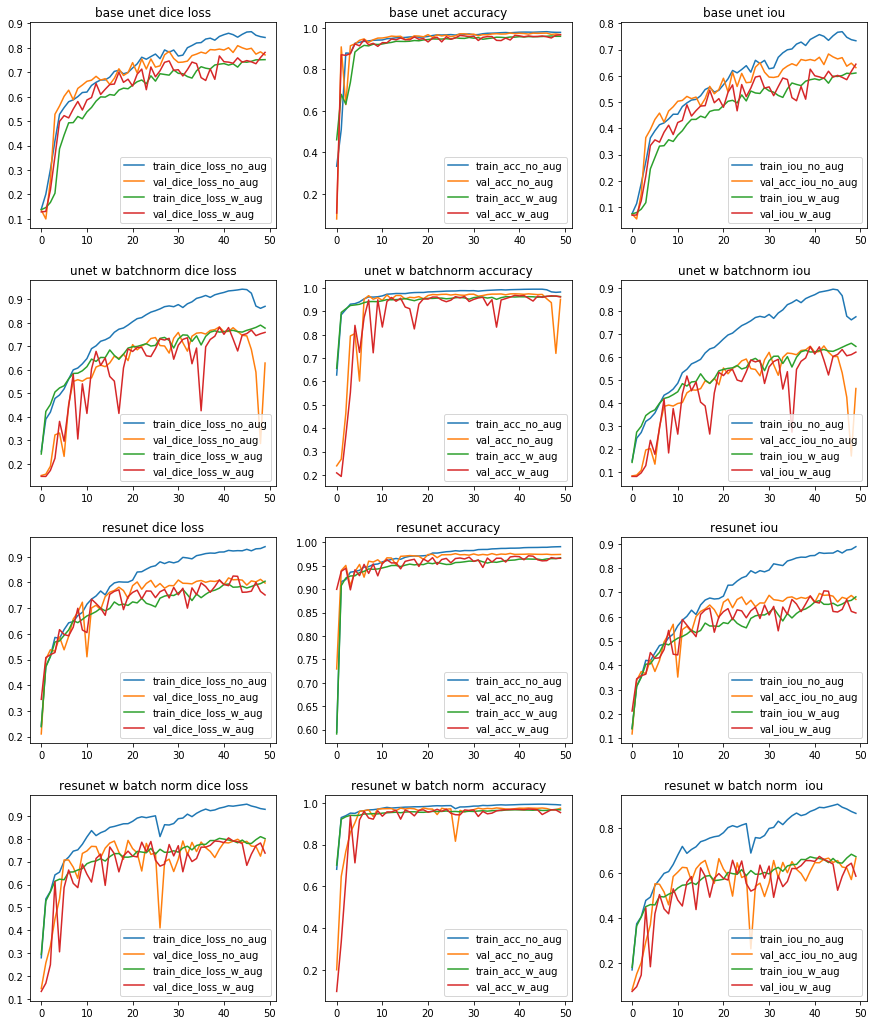

In [6]:
plt.figure(figsize=(15,18))
plt.subplots_adjust(hspace=0.25)

# base unet
plt.subplot(4,3,1)
plt.title('base unet dice loss')
plt.plot(train_dice_loss0,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss0,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss1,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss1,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(4,3,2)
plt.title('base unet accuracy')
plt.plot(train_accuracy0,label='train_acc_no_aug')
plt.plot(val_accuracy0,label='val_acc_no_aug')
plt.plot(train_accuracy1,label='train_acc_w_aug')
plt.plot(val_accuracy1,label='val_acc_w_aug')
plt.legend()

plt.subplot(4,3,3)
plt.title('base unet iou')
plt.plot(train_iou0,label='train_iou_no_aug')
plt.plot(val_iou0,label='val_acc_iou_no_aug')
plt.plot(train_iou1,label='train_iou_w_aug')
plt.plot(val_iou1,label='val_iou_w_aug')
plt.legend()

# unet w batchnorm
plt.subplot(4,3,4)
plt.title('unet w batchnorm dice loss')
plt.plot(train_dice_loss2,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss2,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss3,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss3,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(4,3,5)
plt.title('unet w batchnorm accuracy')
plt.plot(train_accuracy2,label='train_acc_no_aug')
plt.plot(val_accuracy2,label='val_acc_no_aug')
plt.plot(train_accuracy3,label='train_acc_w_aug')
plt.plot(val_accuracy3,label='val_acc_w_aug')
plt.legend()

plt.subplot(4,3,6)
plt.title('unet w batchnorm iou')
plt.plot(train_iou2,label='train_iou_no_aug')
plt.plot(val_iou2,label='val_acc_iou_no_aug')
plt.plot(train_iou3,label='train_iou_w_aug')
plt.plot(val_iou3,label='val_iou_w_aug')
plt.legend()

# resunet no batch norm
plt.subplot(4,3,7)
plt.title('resunet dice loss')
plt.plot(train_dice_loss4,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss4,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss5,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss5,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(4,3,8)
plt.title('resunet accuracy')
plt.plot(train_accuracy4,label='train_acc_no_aug')
plt.plot(val_accuracy4,label='val_acc_no_aug')
plt.plot(train_accuracy5,label='train_acc_w_aug')
plt.plot(val_accuracy5,label='val_acc_w_aug')
plt.legend()

plt.subplot(4,3,9)
plt.title('resunet iou')
plt.plot(train_iou4,label='train_iou_no_aug')
plt.plot(val_iou4,label='val_acc_iou_no_aug')
plt.plot(train_iou5,label='train_iou_w_aug')
plt.plot(val_iou5,label='val_iou_w_aug')
plt.legend()

# resunet no batch norm
plt.subplot(4,3,10)
plt.title('resunet w batch norm dice loss')
plt.plot(train_dice_loss6,label='train_dice_loss_no_aug')
plt.plot(val_dice_loss6,label='val_dice_loss_no_aug')
plt.plot(train_dice_loss7,label='train_dice_loss_w_aug')
plt.plot(val_dice_loss7,label='val_dice_loss_w_aug')
plt.legend()

plt.subplot(4,3,11)
plt.title('resunet w batch norm  accuracy')
plt.plot(train_accuracy6,label='train_acc_no_aug')
plt.plot(val_accuracy6,label='val_acc_no_aug')
plt.plot(train_accuracy7,label='train_acc_w_aug')
plt.plot(val_accuracy7,label='val_acc_w_aug')
plt.legend()

plt.subplot(4,3,12)
plt.title('resunet w batch norm  iou')
plt.plot(train_iou6,label='train_iou_no_aug')
plt.plot(val_iou6,label='val_acc_iou_no_aug')
plt.plot(train_iou7,label='train_iou_w_aug')
plt.plot(val_iou7,label='val_iou_w_aug')
plt.legend()